In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv')
dataset.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
Null values per column:
 carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


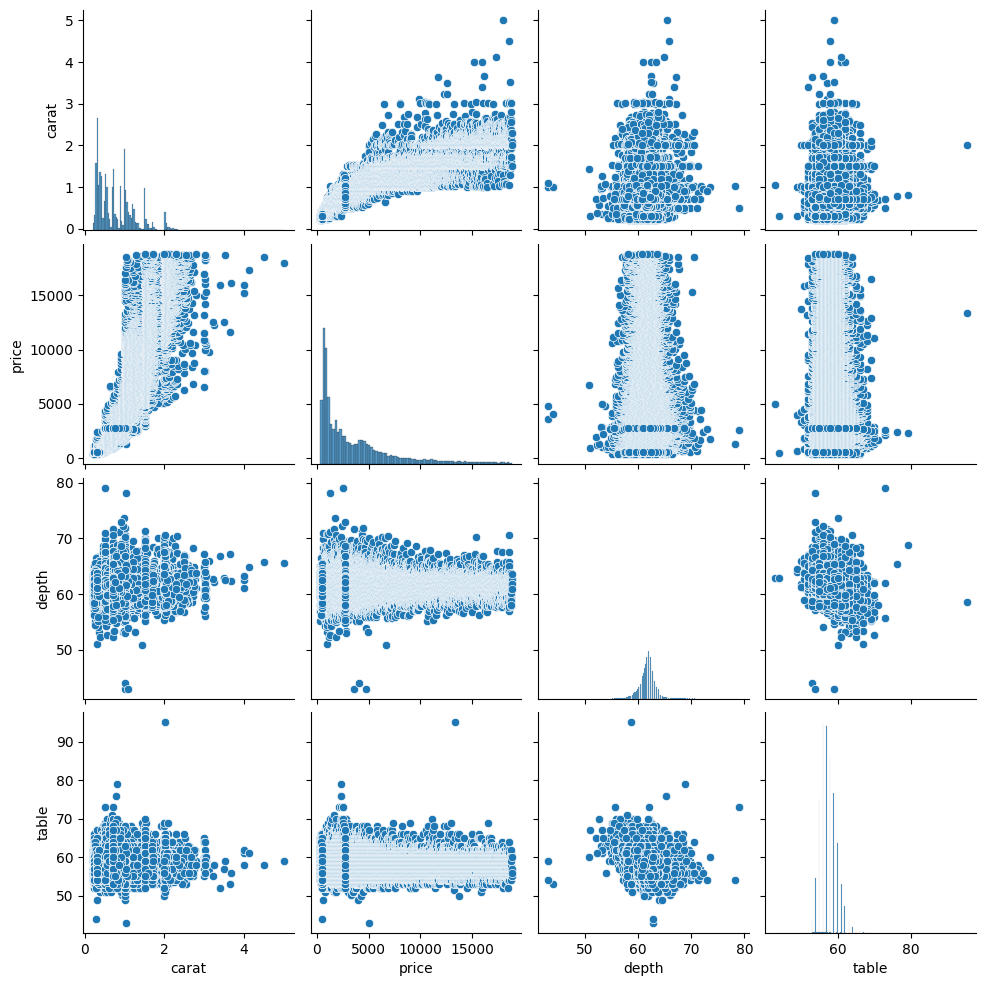

In [3]:
# Summary of dataset
dataset.info()
dataset.describe()

# Check for null values
print("Null values per column:\n", dataset.isnull().sum())

# Initial pairplot to explore relationships
sns.pairplot(dataset[['carat', 'price', 'depth', 'table']])
plt.show()


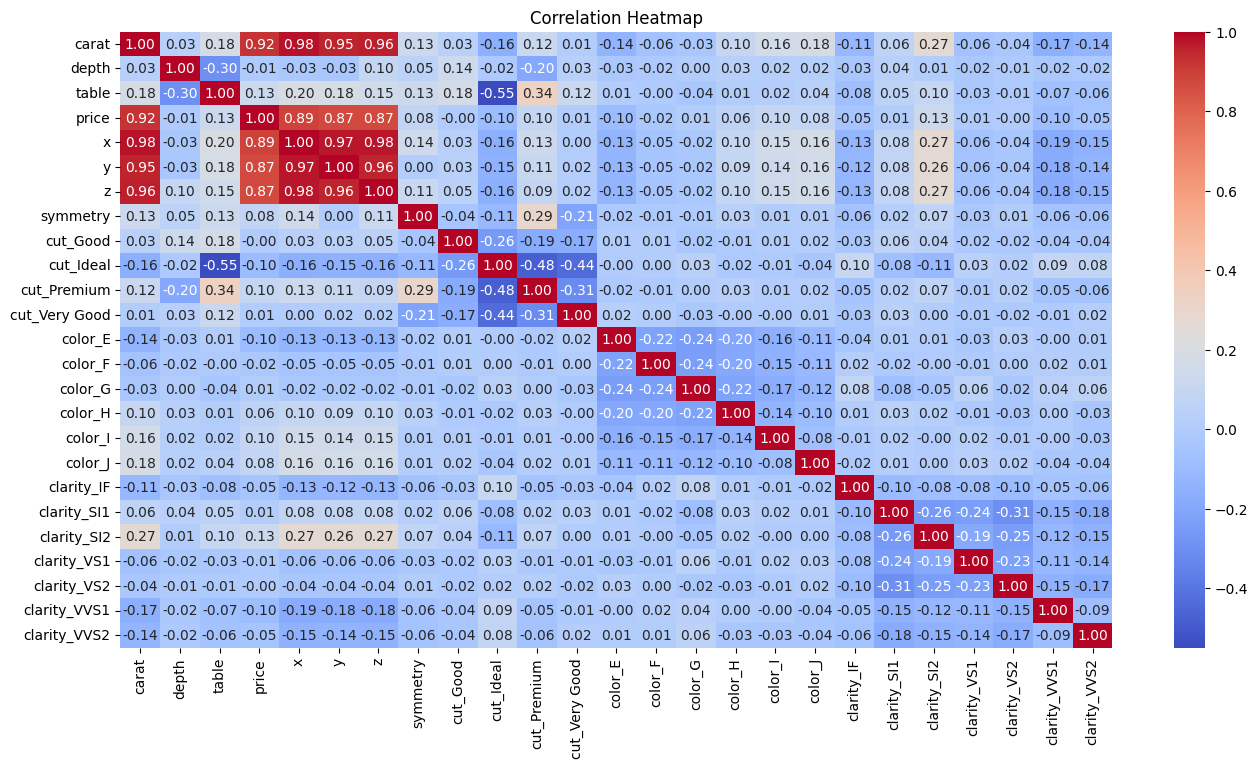

In [4]:
# Create a new feature: symmetry (x/y ratio)
dataset['symmetry'] = dataset['x'] / dataset['y']

# Drop rows with missing or zero values in key features
dataset = dataset[(dataset[['x', 'y', 'z']] > 0).all(axis=1)]

# Convert categorical columns into dummies
dataset_trans = pd.get_dummies(dataset, drop_first=True)

# Define features (X) and target variable (y)
X = dataset_trans.drop(['price', 'x', 'y', 'z'], axis=1)
y = dataset_trans['price']

# Correlation heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(dataset_trans.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}

# Display results
results_df = pd.DataFrame(results).T
print("Model Evaluation:\n", results_df)

# Feature importance (for Random Forest)
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
print(feature_importance_df)


Model Evaluation:
                           RMSE        R2
Linear Regression  1125.692378  0.920959
Lasso              1125.027454  0.921052
KNN                1193.204793  0.911194
Random Forest       595.236714  0.977900
          Feature  Importance
0           carat    0.879803
16    clarity_SI2    0.020026
15    clarity_SI1    0.014785
13        color_J    0.011244
1           depth    0.011015
3        symmetry    0.008971
12        color_I    0.008562
11        color_H    0.007491
18    clarity_VS2    0.005870
20   clarity_VVS2    0.005454
19   clarity_VVS1    0.005267
14     clarity_IF    0.004887
17    clarity_VS1    0.004514
2           table    0.003680
10        color_G    0.003243
5       cut_Ideal    0.001521
9         color_F    0.001265
8         color_E    0.000943
4        cut_Good    0.000684
6     cut_Premium    0.000417
7   cut_Very Good    0.000358


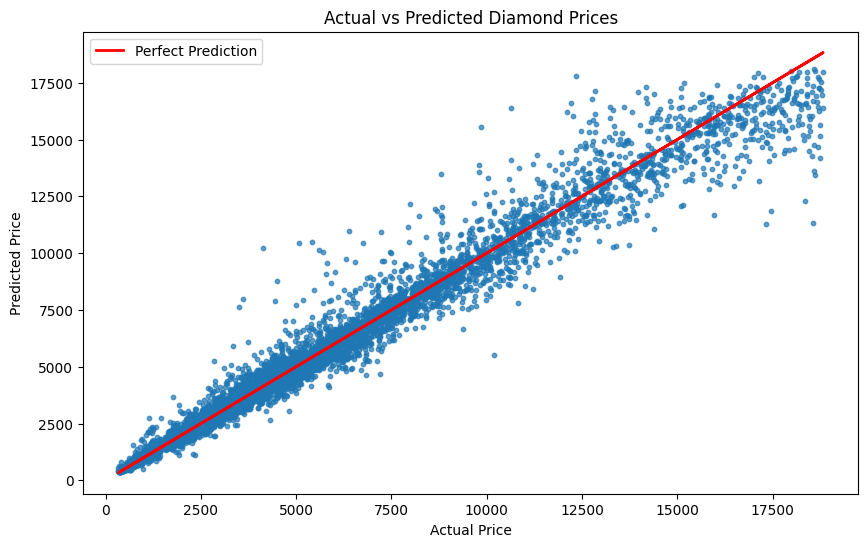

In [7]:
# Random Forest Predictions
y_pred_rf = models["Random Forest"].predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, s=10, alpha=0.7)
plt.plot(y_test, y_test, color='red', linewidth=2, label="Perfect Prediction")
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Diamond Prices')
plt.legend()
plt.show()


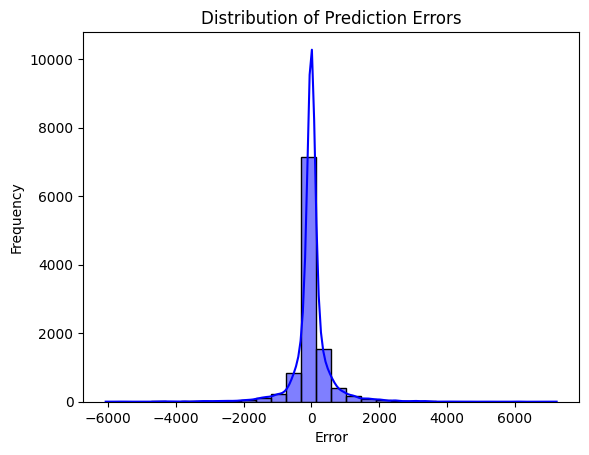

In [8]:
errors = y_test - y_pred_rf
sns.histplot(errors, kde=True, color="blue", bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


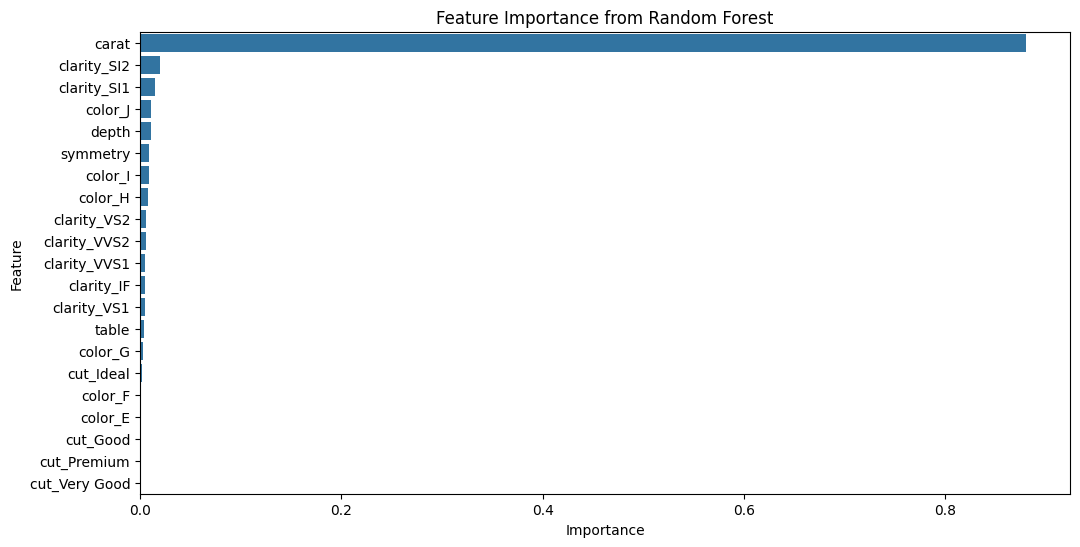

In [9]:
# Bar plot of feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance from Random Forest")
plt.show()


In [10]:
# Save the original feature names (from the training dataset)
feature_columns = X.columns  # Ensure this is from the training data after encoding

# Example new data point
new_data = pd.DataFrame({
    "carat": [1.2], "depth": [62.0], "table": [58.0], "symmetry": [1.02],
    "cut_Good": [0], "cut_Premium": [1], "cut_Very Good": [0],
    "color_E": [1], "color_F": [0], "color_G": [0],
    "clarity_IF": [0], "clarity_SI1": [1], "clarity_VVS1": [0]
})

# Align new_data to the feature_columns, filling missing columns with 0
new_data_aligned = new_data.reindex(columns=feature_columns, fill_value=0)

# Scale the aligned new data
new_data_scaled = scaler.transform(new_data_aligned)

# Predict the price
predicted_price = rf_model.predict(new_data_scaled)
print(f"Predicted Diamond Price: ${predicted_price[0]:.2f}")



Predicted Diamond Price: $6643.44


In [11]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_results[name] = {"Mean RMSE": -scores.mean(), "Std RMSE": scores.std()}

# Display cross-validation results
cv_results_df = pd.DataFrame(cv_results).T
print("Cross-Validation Results:\n", cv_results_df)


Cross-Validation Results:
                      Mean RMSE   Std RMSE
Linear Regression  1163.105178   9.109869
Lasso              1163.324837   9.522352
KNN                1274.962576  34.615801
Random Forest       640.148691  17.527737


In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

# Perform GridSearchCV
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_root_mean_squared_error')
grid_rf.fit(X_train, y_train)

# Best parameters and RMSE
print("Best RF Parameters:", grid_rf.best_params_)
print("Best RF RMSE:", -grid_rf.best_score_)


Best RF Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF RMSE: 633.6274949937097


In [13]:
# Define the parameter grid for KNN
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 10],
    "weights": ["uniform", "distance"]
}

# Perform GridSearchCV
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='neg_root_mean_squared_error')
grid_knn.fit(X_train, y_train)

# Best parameters and RMSE
print("Best KNN Parameters:", grid_knn.best_params_)
print("Best KNN RMSE:", -grid_knn.best_score_)


Best KNN Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best KNN RMSE: 1159.8775930131346


<ipython-input-14-d3dac0e8c7f7>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_eval, x="Model", y="RMSE", palette="viridis")


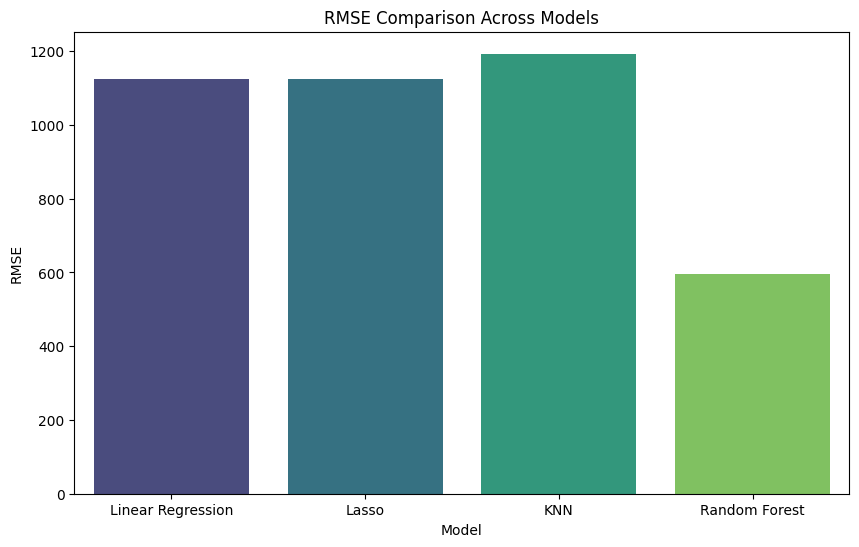

<ipython-input-14-d3dac0e8c7f7>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_eval, x="Model", y="R²", palette="plasma")


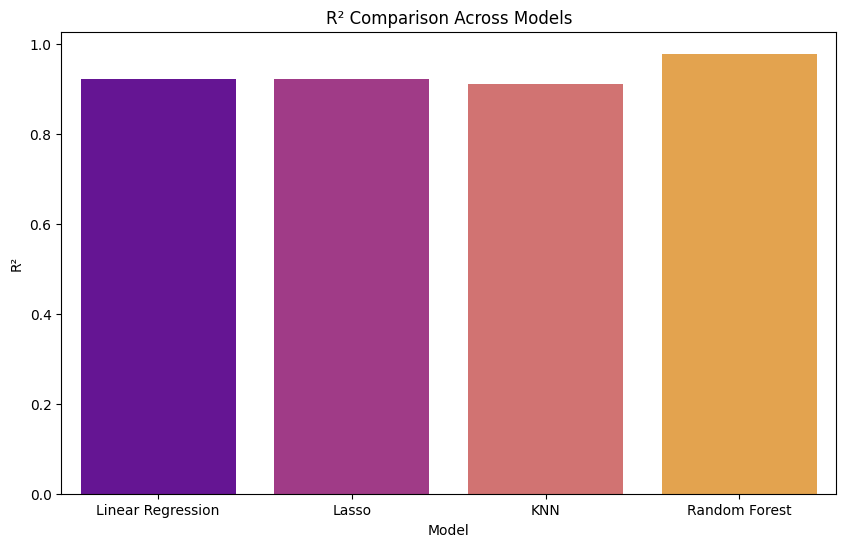

In [14]:
# Combine evaluation metrics into a single DataFrame
model_eval = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso", "KNN", "Random Forest"],
    "RMSE": [results["Linear Regression"]["RMSE"], results["Lasso"]["RMSE"], results["KNN"]["RMSE"], results["Random Forest"]["RMSE"]],
    "R²": [results["Linear Regression"]["R2"], results["Lasso"]["R2"], results["KNN"]["R2"], results["Random Forest"]["R2"]]
})

# Bar plot for RMSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=model_eval, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

# Bar plot for R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=model_eval, x="Model", y="R²", palette="plasma")
plt.title("R² Comparison Across Models")
plt.ylabel("R²")
plt.xlabel("Model")
plt.show()


In [16]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10

# Prepare data
source = ColumnDataSource(dataset)

# Create figure
# Replaced 'plot_width' and 'plot_height' with 'width' and 'height' respectively
plot = figure(title="Diamond Price vs Carat by Cut", x_axis_label="Carat", y_axis_label="Price",
              width=800, height=600, tools="pan,wheel_zoom,box_zoom,reset,hover")

# Map colors to 'cut'
cuts = dataset['cut'].unique()
color_map = factor_cmap('cut', palette=Category10[len(cuts)], factors=cuts)

# Scatter plot
plot.scatter('carat', 'price', source=source, size=8, color=color_map, legend_field='cut', alpha=0.6)

# Display plot
plot.legend.title = "Cut"
show(plot)

In [21]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.transform import transform
from bokeh.palettes import Viridis256

# Activate Bokeh in the notebook environment
output_notebook()

# Compute correlation
correlation = dataset_trans.corr()

# Prepare data for heatmap
corr_df = correlation.stack().reset_index(name='correlation')
corr_df.rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2'}, inplace=True)

# Create data source
corr_source = ColumnDataSource(corr_df)

# Define color mapper
mapper = LinearColorMapper(palette=Viridis256, low=-1, high=1)

# Create figure
# Replaced 'plot_width' and 'plot_height' with 'width' and 'height' respectively
heatmap = figure(
    title="Correlation Heatmap",
    x_range=list(correlation.columns),
    y_range=list(correlation.columns[::-1]),  # Reverse y-range for proper alignment
    x_axis_location="above",
    width=800,  # Changed from plot_width
    height=800,  # Changed from plot_height
    tools="hover",
    tooltips=[("Feature 1", "@Feature1"),
              ("Feature 2", "@Feature2"),
              ("Correlation", "@correlation{0.2f}")]
)

# Add rectangles for heatmap
heatmap.rect(
    x="Feature1",
    y="Feature2",
    width=1,
    height=1,
    source=corr_source,
    line_color=None,
    fill_color=transform("correlation", mapper)
)

# Add color bar
color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0), title="Correlation")
heatmap.add_layout(color_bar, 'right')

# Show the heatmap
show(heatmap)